## Evaluate performance

In [1]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('best_model_max.keras')

In [2]:
commands = ['_background_noise_', 'go', 'max', 'no', 'off', 'on', 'stop',
       'wow']

import sklearn as sk
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(commands)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [3]:
!pip install SpeechRecognition
!pip install pyaudio

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [4]:
import speech_recognition as sr
import pyaudio
import wave
import os
import numpy as np
import scipy
from scipy import io
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque

In [5]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate /1e3)) # 窗口中采样点的个数
    noverlap = int(round(step_size * sample_rate /1e3))
    freqs, times, spec = scipy.signal.spectrogram(audio, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)

    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [6]:
def get_specgram(file_path):
    sample_rate, signal = scipy.io.wavfile.read(file_path)
    signal_padding = np.zeros((16000,))
    #统一输入音频文件长度，当音频文件大于1秒时切尾，当音频长度小于1秒时补零signal_padding np. zeros((16000,))
    if len(signal)>=16000:
        signal_padding = signal[:16000]
    else:
        signal_padding[:len(signal)] = signal
    
    #获取频谱
    _, _, specgram = log_specgram(signal_padding, sample_rate=sample_rate) 
    return specgram

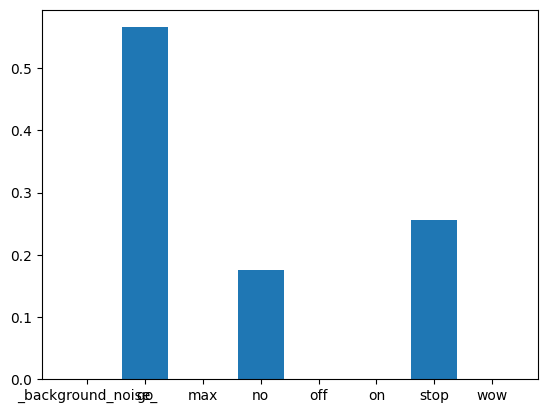

等待声音...


KeyboardInterrupt: 

In [8]:
%matplotlib inline

def detect_sound_and_record(threshold=1000, chunk_size=1024, record_seconds=1, pre_buffer_seconds=0.2, sample_rate=16000):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=chunk_size)

    print("等待声音...")

    pre_buffer = deque(maxlen=int(sample_rate / chunk_size * pre_buffer_seconds))

    while True:
        data = stream.read(chunk_size)
        pre_buffer.append(data)
        audio_data = np.frombuffer(data, dtype=np.int16)
        if np.abs(audio_data).mean() > threshold:
            print("检测到声音! 开始录音...")
            break

    frames = list(pre_buffer)
    for _ in range(0, int(sample_rate / chunk_size * record_seconds)):
        data = stream.read(chunk_size)
        frames.append(data)

    print("录音结束")

    stream.stop_stream()
    stream.close()
    p.terminate()

    # 保存录音
    wf = wave.open("output.wav", 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
    wf.setframerate(sample_rate)
    wf.writeframes(b''.join(frames))
    wf.close()

while True:
    detect_sound_and_record()
    if os.path.isfile(f"output.wav"):
        result = loaded_model.predict(get_specgram(f"output.wav").reshape(-1,99, 161))
        y_pred=np.argmax(result)
        data=result.reshape(8) 
        clear_output(wait=True)
        fig=plt.figure()
        plt.bar(commands, data)
        # plt.savefig(f"testing_result/microphone-results{idx}.png")
        plt.show()

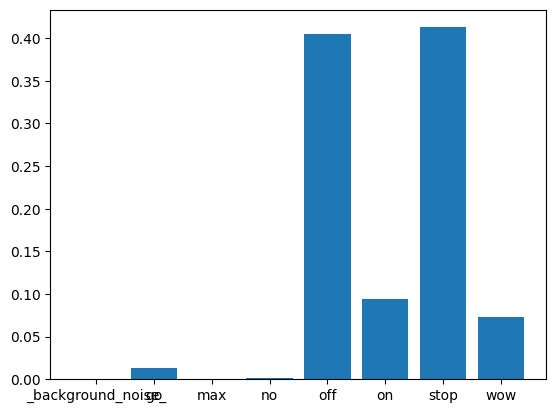

KeyboardInterrupt: 

In [9]:
%matplotlib inline

r = sr.Recognizer()
idx = 0
with sr.Microphone(sample_rate=16000) as source:
    while True:
        r.adjust_for_ambient_noise(source)
        if r.energy_threshold < 200:
            r.energy_threshold= 200

        print(f"Say something! \n {commands}")
        
        audio =r.listen(source)
        idx += 1
        with open(f"testing/microphone-results{idx}.wav", "wb") as f:
            f.write(audio.get_wav_data())
        
        if os.path.isfile(f"testing/microphone-results{idx}.wav"):
            result = loaded_model.predict(get_specgram(f"testing/microphone-results{idx}.wav").reshape(-1,99, 161))
            y_pred=np.argmax(result)
            data=result.reshape(8) 
            clear_output(wait=True)
            fig=plt.figure()
            plt.bar(commands, data)
            plt.savefig(f"testing_result/microphone-results{idx}.png")
            plt.show()
            #os.remove('microphone-results.wav')
        else:
            print('File not exist')

1/1 [==============================] - 0s 33ms/step


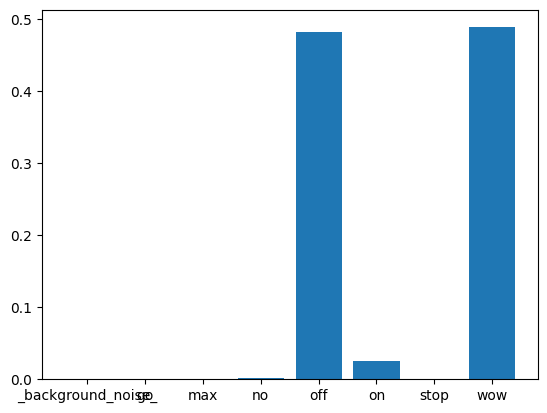

In [12]:
result = loaded_model.predict(get_specgram('trigger_example/3_16khz.wav').reshape(-1,99, 161))
data=result.reshape(8) 
plt.bar(commands, data)
plt.show()